# Notebook 8: MPC with Weather Forecasting

## Hypothesis: Future Information Beats Backtracking

**Key Insight from Previous Notebooks:**
- RL with current-time information cannot beat backtracking
- Backtracking is mathematically optimal for current sun position
- To beat it, we need information backtracking doesn't have

**This Notebook Tests:**
1. **Perfect Forecast (Oracle)** - Upper bound on improvement
2. **Realistic Forecast** - With prediction errors
3. **MPC Optimization** - Optimize over future horizon
4. **RL with Forecast in State** - Learn to use forecast info

**Why Forecasting Could Win:**
- Pre-position tracker before clouds arrive
- Avoid unnecessary movements during transients
- Smooth out response to rapid irradiance changes

In [1]:
# Block TensorFlow
import sys
sys.modules['tensorflow'] = None
sys.modules['tensorboard'] = None

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from dataclasses import dataclass
from typing import Optional, Tuple, Dict, Any, List
import warnings
warnings.filterwarnings('ignore')
import time
from scipy.optimize import minimize
import glob

import pvlib
from pvlib import solarposition, irradiance, tracking, location, shading, atmosphere

import gymnasium as gym
from gymnasium import spaces
import torch
from stable_baselines3 import SAC
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.env_checker import check_env

DEVICE = 'mps' if torch.backends.mps.is_available() else 'cpu'
print(f"✅ Imports successful! Device: {DEVICE.upper()}")

✅ Imports successful! Device: MPS


In [2]:
@dataclass
class SiteConfig:
    name: str = "Phoenix Solar Farm"
    latitude: float = 33.45
    longitude: float = -111.95
    altitude: float = 331
    timezone: str = "US/Arizona"
    gcr: float = 0.35
    axis_azimuth: float = 180
    max_angle: float = 60
    axis_height: float = 1.5
    collector_width: float = 2.2
    terrain_slope: float = 0
    slope_azimuth: float = 180
    capacity_kw: float = 1000
    module_efficiency: float = 0.20
    system_losses: float = 0.14
    temp_coefficient: float = -0.004
    
    @property
    def row_pitch(self) -> float:
        return self.collector_width / self.gcr
    
    @property
    def array_area(self) -> float:
        return self.capacity_kw * 1000 / (1000 * self.module_efficiency)

SITE = SiteConfig()
print(f"Site: {SITE.name}")

Site: Phoenix Solar Farm


## 1. Load Real Weather Data

In [4]:
def load_nsrdb_file(filepath: str) -> pd.DataFrame:
    """Load a single NSRDB CSV file."""
    print(f"Loading {filepath}...")
    df = pd.read_csv(filepath, skiprows=2)
    df['datetime'] = pd.to_datetime(
        df[['Year', 'Month', 'Day', 'Hour', 'Minute']].astype(str).agg('-'.join, axis=1),
        format='%Y-%m-%d-%H-%M'
    )
    df = df.set_index('datetime')
    df = df.rename(columns={'Temperature': 'temp_air', 'Wind Speed': 'wind_speed'})
    df.columns = df.columns.str.lower().str.replace(' ', '_')
    key_cols = ['ghi', 'dni', 'dhi', 'temp_air', 'wind_speed']
    df = df[[c for c in key_cols if c in df.columns]]
    print(f"   Loaded {len(df):,} records")
    return df

def load_multi_year_data(file_paths: List[str]) -> pd.DataFrame:
    """Load multiple NSRDB files and combine."""
    all_data = [load_nsrdb_file(f) for f in file_paths]
    combined = pd.concat(all_data, axis=0).sort_index()
    combined = combined[~combined.index.duplicated(keep='first')]
    if combined.index.tz is None:
        combined.index = combined.index.tz_localize('US/Arizona')
    print(f"\n✅ Total: {len(combined):,} records")
    return combined

# Load data
file_paths = sorted(glob.glob('uploads/*.csv'))
print(f"Found {len(file_paths)} CSV files")
nsrdb_data = load_multi_year_data(file_paths)

# Detect interval
time_diff = nsrdb_data.index.to_series().diff().median()
INTERVAL_MINUTES = time_diff.total_seconds() / 60
print(f"Data interval: {INTERVAL_MINUTES:.0f} minutes")

Found 7 CSV files
Loading uploads/1305537_33.44_-112.09_2018.csv...
   Loaded 52,560 records
Loading uploads/1305537_33.44_-112.09_2019.csv...
   Loaded 52,560 records
Loading uploads/1305537_33.44_-112.09_2020.csv...
   Loaded 52,560 records
Loading uploads/1305537_33.44_-112.09_2021.csv...
   Loaded 52,560 records
Loading uploads/1305537_33.44_-112.09_2022.csv...
   Loaded 52,560 records
Loading uploads/1305537_33.44_-112.09_2023.csv...
   Loaded 52,560 records
Loading uploads/1305537_33.44_-112.09_2024.csv...
   Loaded 52,560 records

✅ Total: 367,920 records
Data interval: 10 minutes


In [5]:
# Use 2023 for testing (held out from previous training)
test_data = nsrdb_data[nsrdb_data.index.year == 2023]
print(f"Test data: {len(test_data):,} records from 2023")

Test data: 52,560 records from 2023


## 2. Core Physics Functions

In [6]:
class TrackerPhysics:
    """Core physics calculations for tracker optimization."""
    
    def __init__(self, site: SiteConfig):
        self.site = site
    
    def get_backtracking_angle(self, solar_zenith: float, solar_azimuth: float) -> float:
        """Calculate geometric backtracking angle."""
        if solar_zenith >= 90:
            return 0.0
        
        tracking_data = tracking.singleaxis(
            apparent_zenith=solar_zenith,
            apparent_azimuth=solar_azimuth,
            axis_tilt=0,
            axis_azimuth=self.site.axis_azimuth,
            max_angle=self.site.max_angle,
            backtrack=True,
            gcr=self.site.gcr
        )
        angle = tracking_data['tracker_theta']
        return float(angle) if not pd.isna(angle) else 0.0
    
    def calculate_poa(self, tracker_angle: float, solar_zenith: float, solar_azimuth: float,
                      dni: float, ghi: float, dhi: float, timestamp) -> float:
        """Calculate plane-of-array irradiance."""
        if solar_zenith >= 90 or ghi <= 0:
            return 0.0
        
        surface_tilt = abs(tracker_angle)
        if tracker_angle > 0:
            surface_azimuth = (self.site.axis_azimuth + 90) % 360
        elif tracker_angle < 0:
            surface_azimuth = (self.site.axis_azimuth - 90) % 360
        else:
            surface_azimuth = self.site.axis_azimuth
        
        try:
            dni_extra = irradiance.get_extra_radiation(timestamp)
            airmass = atmosphere.get_relative_airmass(solar_zenith)
            poa = irradiance.get_total_irradiance(
                surface_tilt=surface_tilt, surface_azimuth=surface_azimuth,
                solar_zenith=solar_zenith, solar_azimuth=solar_azimuth,
                dni=dni, ghi=ghi, dhi=dhi, dni_extra=dni_extra, airmass=airmass, model='perez'
            )
            return max(0.0, float(poa['poa_global']))
        except:
            return max(0.0, ghi)
    
    def calculate_shading(self, tracker_angle: float, solar_zenith: float, solar_azimuth: float) -> float:
        """Calculate inter-row shading fraction."""
        if solar_zenith >= 90:
            return 1.0
        try:
            shaded = shading.shaded_fraction1d(
                solar_zenith=solar_zenith, solar_azimuth=solar_azimuth,
                axis_azimuth=self.site.axis_azimuth, shaded_row_rotation=tracker_angle,
                collector_width=self.site.collector_width, pitch=self.site.row_pitch,
                axis_tilt=0, cross_axis_slope=self.site.terrain_slope
            )
            return float(shaded)
        except:
            return 0.0
    
    def calculate_power(self, poa: float, temp_air: float, shading_frac: float) -> float:
        """Calculate power output in kW."""
        if poa <= 0:
            return 0.0
        
        temp_cell = temp_air + 0.03 * poa
        temp_factor = max(0.5, min(1.1, 1 + self.site.temp_coefficient * (temp_cell - 25)))
        effective_poa = poa * (1 - shading_frac)
        
        power_kw = (
            effective_poa / 1000 
            * self.site.array_area 
            * self.site.module_efficiency 
            * temp_factor 
            * (1 - self.site.system_losses)
        )
        return min(max(0.0, power_kw), self.site.capacity_kw)
    
    def calculate_energy(self, tracker_angle: float, weather_row, solar_row, 
                         timestamp, interval_hours: float) -> float:
        """Calculate energy for a single timestep."""
        poa = self.calculate_poa(
            tracker_angle, solar_row['apparent_zenith'], solar_row['azimuth'],
            weather_row['dni'], weather_row['ghi'], weather_row['dhi'], timestamp
        )
        shading_frac = self.calculate_shading(
            tracker_angle, solar_row['apparent_zenith'], solar_row['azimuth']
        )
        power = self.calculate_power(poa, weather_row.get('temp_air', 25), shading_frac)
        return power * interval_hours


physics = TrackerPhysics(SITE)
print("TrackerPhysics initialized!")

TrackerPhysics initialized!


## 3. Forecast Models

In [7]:
class ForecastModel:
    """Base class for irradiance forecasting."""
    
    def __init__(self, weather_data: pd.DataFrame, horizon_steps: int = 6):
        """
        Args:
            weather_data: Full weather DataFrame
            horizon_steps: Number of future steps to forecast
        """
        self.weather_data = weather_data
        self.horizon_steps = horizon_steps
    
    def get_forecast(self, current_time) -> pd.DataFrame:
        """Return forecast for next horizon_steps."""
        raise NotImplementedError


class PerfectForecast(ForecastModel):
    """Oracle forecast - perfect knowledge of future (upper bound)."""
    
    def get_forecast(self, current_time) -> pd.DataFrame:
        """Return actual future values (perfect forecast)."""
        try:
            idx = self.weather_data.index.get_loc(current_time)
            end_idx = min(idx + self.horizon_steps + 1, len(self.weather_data))
            return self.weather_data.iloc[idx:end_idx].copy()
        except:
            return pd.DataFrame()


class PersistenceForecast(ForecastModel):
    """Naive forecast - assume current conditions persist."""
    
    def get_forecast(self, current_time) -> pd.DataFrame:
        """Return current values repeated for horizon."""
        try:
            current = self.weather_data.loc[current_time]
            # Create future timestamps
            interval = self.weather_data.index.to_series().diff().median()
            future_times = [current_time + interval * i for i in range(self.horizon_steps + 1)]
            
            # Repeat current values
            forecast = pd.DataFrame([current] * len(future_times), index=future_times)
            return forecast
        except:
            return pd.DataFrame()


class NoisyForecast(ForecastModel):
    """Realistic forecast with increasing error over horizon."""
    
    def __init__(self, weather_data: pd.DataFrame, horizon_steps: int = 6,
                 base_error: float = 0.05, error_growth: float = 0.03):
        """
        Args:
            base_error: Error at t+1 (e.g., 0.05 = 5%)
            error_growth: Additional error per step (e.g., 0.03 = 3% per step)
        """
        super().__init__(weather_data, horizon_steps)
        self.base_error = base_error
        self.error_growth = error_growth
        self.rng = np.random.default_rng(42)
    
    def get_forecast(self, current_time) -> pd.DataFrame:
        """Return actual future with noise."""
        try:
            idx = self.weather_data.index.get_loc(current_time)
            end_idx = min(idx + self.horizon_steps + 1, len(self.weather_data))
            forecast = self.weather_data.iloc[idx:end_idx].copy()
            
            # Add increasing noise
            for i, (ts, row) in enumerate(forecast.iterrows()):
                if i == 0:
                    continue  # No error for current time
                
                error_pct = self.base_error + self.error_growth * (i - 1)
                
                for col in ['ghi', 'dni', 'dhi']:
                    if col in forecast.columns:
                        noise = self.rng.normal(1.0, error_pct)
                        forecast.loc[ts, col] = max(0, row[col] * noise)
            
            return forecast
        except:
            return pd.DataFrame()


print("Forecast models defined!")
print(f"  - PerfectForecast: Oracle (upper bound)")
print(f"  - PersistenceForecast: Naive baseline")
print(f"  - NoisyForecast: Realistic with errors")

Forecast models defined!
  - PerfectForecast: Oracle (upper bound)
  - PersistenceForecast: Naive baseline
  - NoisyForecast: Realistic with errors


## 4. MPC Controller

In [8]:
class MPCController:
    """
    Model Predictive Control for tracker optimization.
    
    Optimizes: max Σ Energy(angle_t) - λ * Σ |angle_t - angle_{t-1}|
    Over: horizon_steps into the future
    """
    
    def __init__(self, site: SiteConfig, physics: TrackerPhysics,
                 horizon_steps: int = 6, movement_penalty: float = 0.01):
        self.site = site
        self.physics = physics
        self.horizon_steps = horizon_steps
        self.movement_penalty = movement_penalty
    
    def optimize(self, current_angle: float, forecast: pd.DataFrame,
                 solar_positions: pd.DataFrame, interval_hours: float) -> float:
        """
        Find optimal current angle given forecast.
        
        Returns: Optimal angle for current timestep
        """
        if len(forecast) == 0:
            return current_angle
        
        n_steps = min(len(forecast), self.horizon_steps)
        
        def objective(angles):
            """Negative total energy + movement penalty."""
            total_energy = 0
            total_movement = 0
            prev_angle = current_angle
            
            for i, (ts, weather) in enumerate(forecast.iloc[:n_steps].iterrows()):
                if i >= len(angles):
                    break
                    
                angle = angles[i]
                
                # Get solar position
                if ts in solar_positions.index:
                    solar = solar_positions.loc[ts]
                else:
                    continue
                
                # Calculate energy
                energy = self.physics.calculate_energy(
                    angle, weather, solar, ts, interval_hours
                )
                total_energy += energy
                
                # Movement penalty
                total_movement += abs(angle - prev_angle)
                prev_angle = angle
            
            # Minimize negative energy + movement cost
            return -total_energy + self.movement_penalty * total_movement
        
        # Initial guess: backtracking angles
        x0 = []
        for ts in forecast.index[:n_steps]:
            if ts in solar_positions.index:
                solar = solar_positions.loc[ts]
                bt_angle = self.physics.get_backtracking_angle(
                    solar['apparent_zenith'], solar['azimuth']
                )
                x0.append(bt_angle)
            else:
                x0.append(current_angle)
        
        if len(x0) == 0:
            return current_angle
        
        # Bounds
        bounds = [(-self.site.max_angle, self.site.max_angle)] * len(x0)
        
        # Optimize
        try:
            result = minimize(
                objective, x0, method='L-BFGS-B', bounds=bounds,
                options={'maxiter': 50}
            )
            return result.x[0]  # Return first (current) angle
        except:
            return x0[0]  # Fallback to backtracking


print("MPCController defined!")

MPCController defined!


## 5. Simulation Framework

In [9]:
def simulate_day(date: str, weather_data: pd.DataFrame, site: SiteConfig,
                 controller, forecast_model=None, interval_minutes: float = 10) -> Dict:
    """
    Simulate a full day with given controller.
    
    Args:
        controller: 'backtracking', 'mpc', or callable
        forecast_model: ForecastModel instance (required for MPC)
    
    Returns:
        Dict with total energy, movement, and history
    """
    physics = TrackerPhysics(site)
    interval_hours = interval_minutes / 60
    
    # Get day's data
    date_ts = pd.Timestamp(date, tz=site.timezone)
    day_start = date_ts.normalize()
    day_end = day_start + timedelta(days=1)
    day_weather = weather_data[day_start:day_end]
    
    if len(day_weather) == 0:
        return {'energy': 0, 'movement': 0, 'history': []}
    
    # Calculate solar positions
    solar_pos = solarposition.get_solarposition(
        day_weather.index, site.latitude, site.longitude, site.altitude
    )
    
    # Filter to daytime
    daytime_mask = solar_pos['apparent_elevation'] > 0
    daytime_times = day_weather.index[daytime_mask]
    
    if len(daytime_times) == 0:
        return {'energy': 0, 'movement': 0, 'history': []}
    
    # MPC controller setup
    mpc = None
    if controller == 'mpc' and forecast_model is not None:
        mpc = MPCController(site, physics, horizon_steps=6, movement_penalty=0.01)
    
    # Simulate
    total_energy = 0
    total_movement = 0
    current_angle = 0
    history = []
    
    for ts in daytime_times:
        weather = day_weather.loc[ts]
        solar = solar_pos.loc[ts]
        
        # Determine tracker angle
        if controller == 'backtracking':
            new_angle = physics.get_backtracking_angle(
                solar['apparent_zenith'], solar['azimuth']
            )
        elif controller == 'mpc' and mpc is not None:
            forecast = forecast_model.get_forecast(ts)
            new_angle = mpc.optimize(current_angle, forecast, solar_pos, interval_hours)
        elif callable(controller):
            new_angle = controller(ts, weather, solar, current_angle, forecast_model)
        else:
            new_angle = current_angle
        
        # Clip angle
        new_angle = np.clip(new_angle, -site.max_angle, site.max_angle)
        
        # Calculate energy
        energy = physics.calculate_energy(new_angle, weather, solar, ts, interval_hours)
        movement = abs(new_angle - current_angle)
        
        total_energy += energy
        total_movement += movement
        
        history.append({
            'time': ts,
            'angle': new_angle,
            'bt_angle': physics.get_backtracking_angle(solar['apparent_zenith'], solar['azimuth']),
            'energy': energy,
            'ghi': weather['ghi'],
            'dni': weather['dni'],
        })
        
        current_angle = new_angle
    
    return {
        'energy': total_energy,
        'movement': total_movement,
        'history': pd.DataFrame(history)
    }


print("Simulation framework defined!")

Simulation framework defined!


## 6. Test MPC vs Backtracking

In [10]:
# Find interesting test days
test_daytime = test_data[test_data['ghi'] > 0]
test_daytime['diffuse_fraction'] = test_daytime['dhi'] / test_daytime['ghi'].replace(0, 1)

# Daily diffuse fraction
daily_diffuse = test_daytime.groupby(test_daytime.index.date)['diffuse_fraction'].mean()

# Select test days
clear_days = [str(d) for d in daily_diffuse[daily_diffuse < 0.2].index[:5]]
cloudy_days = [str(d) for d in daily_diffuse[daily_diffuse > 0.4].index[:5]]
variable_days = [str(d) for d in daily_diffuse[(daily_diffuse >= 0.2) & (daily_diffuse <= 0.4)].index[:5]]

print(f"Test days selected:")
print(f"  Clear (diffuse < 0.2): {len(clear_days)}")
print(f"  Variable (0.2-0.4): {len(variable_days)}")
print(f"  Cloudy (> 0.4): {len(cloudy_days)}")

Test days selected:
  Clear (diffuse < 0.2): 5
  Variable (0.2-0.4): 5
  Cloudy (> 0.4): 5


In [11]:
# Test on a single cloudy day first
test_day = cloudy_days[0] if cloudy_days else clear_days[0]
print(f"Testing on: {test_day}")

# Backtracking baseline
bt_result = simulate_day(test_day, test_data, SITE, 'backtracking', interval_minutes=INTERVAL_MINUTES)
print(f"\nBacktracking: {bt_result['energy']:.1f} kWh, movement: {bt_result['movement']:.0f}°")

# MPC with perfect forecast
perfect_forecast = PerfectForecast(test_data, horizon_steps=6)
mpc_perfect = simulate_day(test_day, test_data, SITE, 'mpc', perfect_forecast, interval_minutes=INTERVAL_MINUTES)
print(f"MPC (Perfect): {mpc_perfect['energy']:.1f} kWh, movement: {mpc_perfect['movement']:.0f}°")

# MPC with noisy forecast
noisy_forecast = NoisyForecast(test_data, horizon_steps=6, base_error=0.10, error_growth=0.05)
mpc_noisy = simulate_day(test_day, test_data, SITE, 'mpc', noisy_forecast, interval_minutes=INTERVAL_MINUTES)
print(f"MPC (Noisy):   {mpc_noisy['energy']:.1f} kWh, movement: {mpc_noisy['movement']:.0f}°")

# MPC with persistence forecast
persist_forecast = PersistenceForecast(test_data, horizon_steps=6)
mpc_persist = simulate_day(test_day, test_data, SITE, 'mpc', persist_forecast, interval_minutes=INTERVAL_MINUTES)
print(f"MPC (Persist): {mpc_persist['energy']:.1f} kWh, movement: {mpc_persist['movement']:.0f}°")

# Calculate differences
print(f"\nDifference vs Backtracking:")
print(f"  MPC Perfect: {(mpc_perfect['energy']/bt_result['energy']-1)*100:+.2f}%")
print(f"  MPC Noisy:   {(mpc_noisy['energy']/bt_result['energy']-1)*100:+.2f}%")
print(f"  MPC Persist: {(mpc_persist['energy']/bt_result['energy']-1)*100:+.2f}%")

Testing on: 2023-01-01

Backtracking: 73.0 kWh, movement: 237°
MPC (Perfect): 76.8 kWh, movement: 286°
MPC (Noisy):   76.8 kWh, movement: 286°
MPC (Persist): 78.5 kWh, movement: 277°

Difference vs Backtracking:
  MPC Perfect: +5.27%
  MPC Noisy:   +5.27%
  MPC Persist: +7.57%


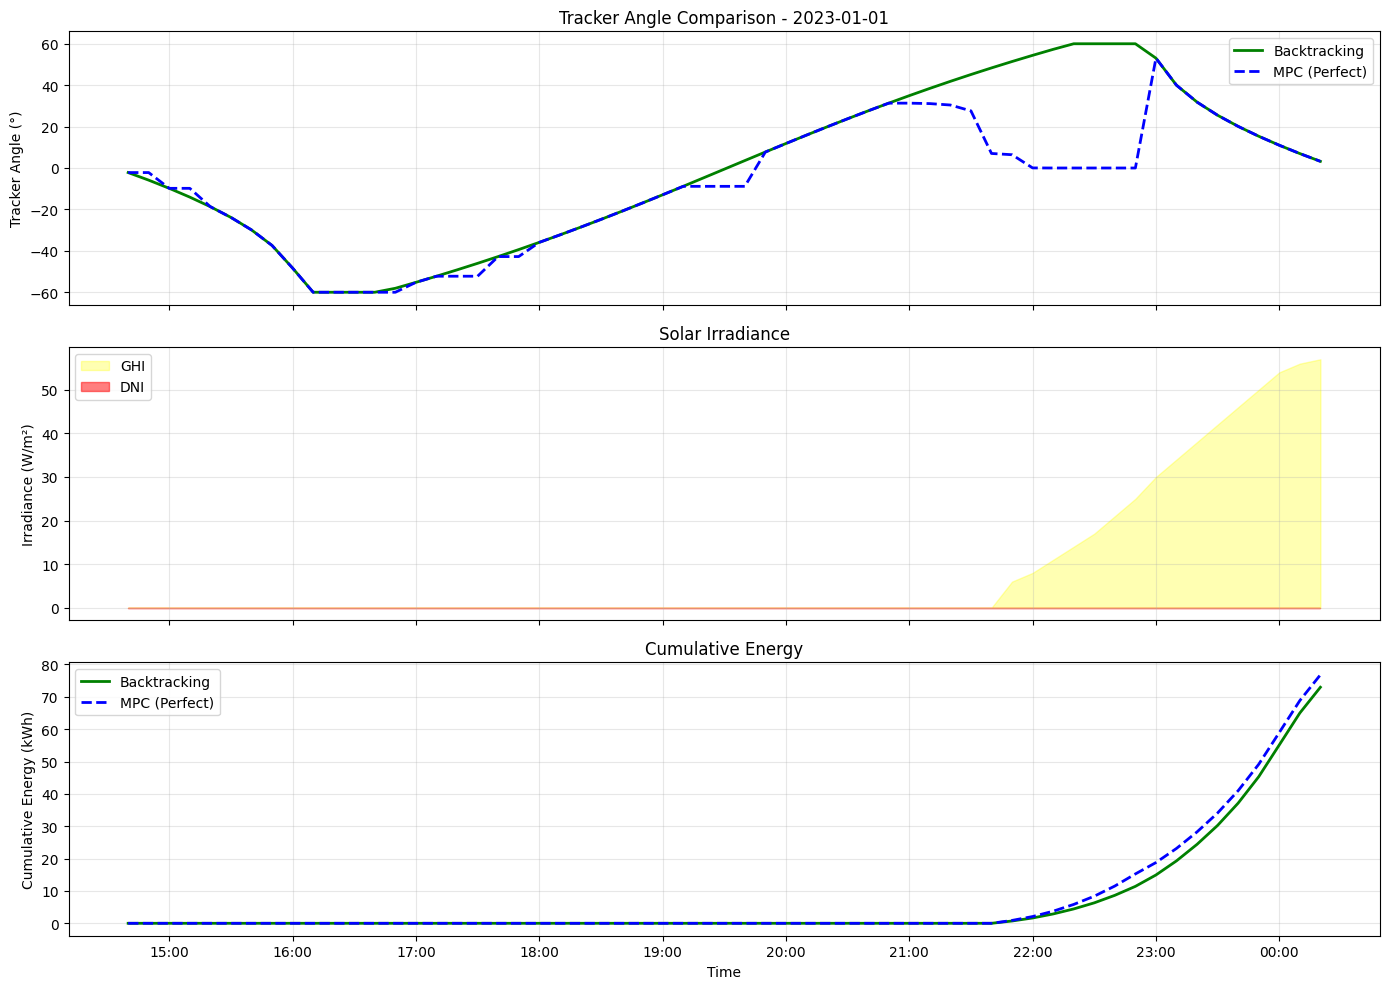

In [12]:
# Visualize the day
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

bt_hist = bt_result['history']
mpc_hist = mpc_perfect['history']

# Angles
ax1 = axes[0]
ax1.plot(bt_hist['time'], bt_hist['angle'], 'g-', label='Backtracking', linewidth=2)
ax1.plot(mpc_hist['time'], mpc_hist['angle'], 'b--', label='MPC (Perfect)', linewidth=2)
ax1.set_ylabel('Tracker Angle (°)')
ax1.set_title(f'Tracker Angle Comparison - {test_day}')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Irradiance
ax2 = axes[1]
ax2.fill_between(bt_hist['time'], 0, bt_hist['ghi'], alpha=0.3, color='yellow', label='GHI')
ax2.fill_between(bt_hist['time'], 0, bt_hist['dni'], alpha=0.5, color='red', label='DNI')
ax2.set_ylabel('Irradiance (W/m²)')
ax2.set_title('Solar Irradiance')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Cumulative energy
ax3 = axes[2]
ax3.plot(bt_hist['time'], bt_hist['energy'].cumsum(), 'g-', label='Backtracking', linewidth=2)
ax3.plot(mpc_hist['time'], mpc_hist['energy'].cumsum(), 'b--', label='MPC (Perfect)', linewidth=2)
ax3.set_ylabel('Cumulative Energy (kWh)')
ax3.set_xlabel('Time')
ax3.set_title('Cumulative Energy')
ax3.legend()
ax3.grid(True, alpha=0.3)

import matplotlib.dates as mdates
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

plt.tight_layout()
plt.show()

## 7. Full Evaluation Across Weather Types

In [13]:
def evaluate_controllers(days: List[str], weather_data: pd.DataFrame, 
                         site: SiteConfig, interval_minutes: float) -> pd.DataFrame:
    """
    Evaluate all controllers on given days.
    """
    results = []
    
    perfect_fc = PerfectForecast(weather_data, horizon_steps=6)
    noisy_fc = NoisyForecast(weather_data, horizon_steps=6, base_error=0.10, error_growth=0.05)
    persist_fc = PersistenceForecast(weather_data, horizon_steps=6)
    
    for day in days:
        print(f"  Evaluating {day}...")
        
        # Backtracking
        bt = simulate_day(day, weather_data, site, 'backtracking', interval_minutes=interval_minutes)
        
        # MPC variants
        mpc_perf = simulate_day(day, weather_data, site, 'mpc', perfect_fc, interval_minutes=interval_minutes)
        mpc_noisy = simulate_day(day, weather_data, site, 'mpc', noisy_fc, interval_minutes=interval_minutes)
        mpc_pers = simulate_day(day, weather_data, site, 'mpc', persist_fc, interval_minutes=interval_minutes)
        
        if bt['energy'] > 0:
            results.append({
                'date': day,
                'bt_energy': bt['energy'],
                'mpc_perfect': mpc_perf['energy'],
                'mpc_noisy': mpc_noisy['energy'],
                'mpc_persist': mpc_pers['energy'],
                'diff_perfect': (mpc_perf['energy'] / bt['energy'] - 1) * 100,
                'diff_noisy': (mpc_noisy['energy'] / bt['energy'] - 1) * 100,
                'diff_persist': (mpc_pers['energy'] / bt['energy'] - 1) * 100,
            })
    
    return pd.DataFrame(results)


# Evaluate on all test days
print("Evaluating on CLEAR days:")
clear_results = evaluate_controllers(clear_days, test_data, SITE, INTERVAL_MINUTES)

print("\nEvaluating on VARIABLE days:")
variable_results = evaluate_controllers(variable_days, test_data, SITE, INTERVAL_MINUTES)

print("\nEvaluating on CLOUDY days:")
cloudy_results = evaluate_controllers(cloudy_days, test_data, SITE, INTERVAL_MINUTES)

Evaluating on CLEAR days:
  Evaluating 2023-01-26...
  Evaluating 2023-01-27...
  Evaluating 2023-02-02...
  Evaluating 2023-02-09...
  Evaluating 2023-02-10...

Evaluating on VARIABLE days:
  Evaluating 2023-01-06...
  Evaluating 2023-01-07...
  Evaluating 2023-01-09...
  Evaluating 2023-01-12...
  Evaluating 2023-01-13...

Evaluating on CLOUDY days:
  Evaluating 2023-01-01...
  Evaluating 2023-01-02...
  Evaluating 2023-01-03...
  Evaluating 2023-01-04...
  Evaluating 2023-01-05...


In [14]:
# Summary by weather type
print("\n" + "="*80)
print("  MPC vs BACKTRACKING RESULTS")
print("="*80)

for name, results in [('Clear', clear_results), ('Variable', variable_results), ('Cloudy', cloudy_results)]:
    if len(results) > 0:
        print(f"\n{name} Days ({len(results)} days):")
        print(f"  MPC (Perfect Forecast): {results['diff_perfect'].mean():+.2f}% avg")
        print(f"  MPC (Noisy Forecast):   {results['diff_noisy'].mean():+.2f}% avg")
        print(f"  MPC (Persistence):      {results['diff_persist'].mean():+.2f}% avg")
        print(f"  Best day improvement:   {results['diff_perfect'].max():+.2f}%")


  MPC vs BACKTRACKING RESULTS

Clear Days (5 days):
  MPC (Perfect Forecast): +0.01% avg
  MPC (Noisy Forecast):   +0.01% avg
  MPC (Persistence):      +0.01% avg
  Best day improvement:   +0.01%

Variable Days (5 days):
  MPC (Perfect Forecast): +0.01% avg
  MPC (Noisy Forecast):   +0.01% avg
  MPC (Persistence):      +0.02% avg
  Best day improvement:   +0.06%

Cloudy Days (5 days):
  MPC (Perfect Forecast): +3.66% avg
  MPC (Noisy Forecast):   +3.88% avg
  MPC (Persistence):      +4.85% avg
  Best day improvement:   +7.63%


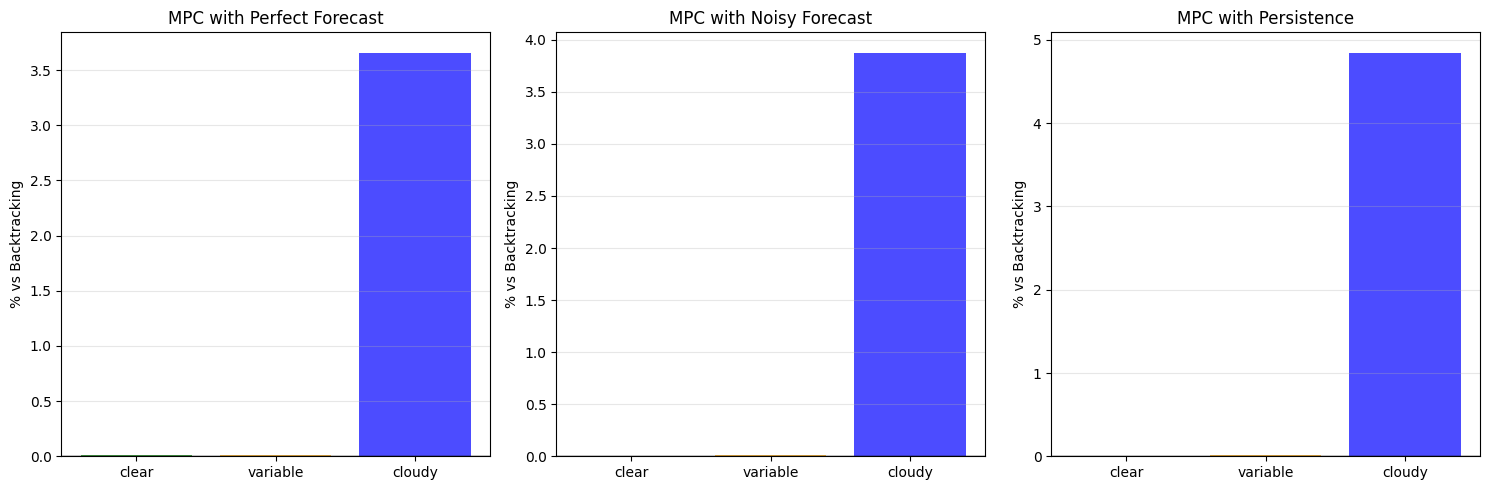

In [15]:
# Combine all results
all_results = pd.concat([
    clear_results.assign(weather='clear'),
    variable_results.assign(weather='variable'),
    cloudy_results.assign(weather='cloudy')
])

# Plot comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, (name, col) in enumerate([('Perfect Forecast', 'diff_perfect'), 
                                   ('Noisy Forecast', 'diff_noisy'),
                                   ('Persistence', 'diff_persist')]):
    ax = axes[i]
    
    for weather, color in [('clear', 'green'), ('variable', 'orange'), ('cloudy', 'blue')]:
        subset = all_results[all_results['weather'] == weather]
        if len(subset) > 0:
            ax.bar([weather], [subset[col].mean()], color=color, alpha=0.7, label=weather)
    
    ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax.set_ylabel('% vs Backtracking')
    ax.set_title(f'MPC with {name}')
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 8. RL with Forecast in State

In [16]:
class ForecastTrackerEnv(gym.Env):
    """
    Tracker environment with forecast information in state.
    
    State includes:
    - Current conditions (10 features)
    - Forecast for next N steps (3 features × N steps)
    """
    
    metadata = {'render_modes': ['human']}
    
    def __init__(
        self,
        weather_data: pd.DataFrame,
        site: SiteConfig,
        forecast_model: ForecastModel,
        forecast_steps: int = 3,  # How many future steps to include
        available_dates: Optional[List[str]] = None,
        random_seed: Optional[int] = None,
        movement_penalty: float = 0.001,
    ):
        super().__init__()
        
        self.site = site
        self.weather_data = weather_data
        self.forecast_model = forecast_model
        self.forecast_steps = forecast_steps
        self.movement_penalty = movement_penalty
        self.rng = np.random.default_rng(random_seed)
        self.physics = TrackerPhysics(site)
        
        # Detect interval
        time_diff = weather_data.index.to_series().diff().median()
        self.interval_hours = time_diff.total_seconds() / 3600
        
        # Available dates
        if available_dates:
            self.available_dates = [pd.Timestamp(d, tz=site.timezone) for d in available_dates]
        else:
            self.available_dates = list(weather_data.index.normalize().unique())
        
        # State: 10 current + 3 per forecast step (ghi, dni, diffuse_frac)
        self.state_dim = 10 + 3 * forecast_steps
        self.observation_space = spaces.Box(low=-1.0, high=1.0, shape=(self.state_dim,), dtype=np.float32)
        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32)
        
        # Episode state
        self.day_data = None
        self.solar_pos = None
        self.current_step = 0
        self.current_angle = 0.0
        self.episode_energy = 0.0
        self.history = []
    
    def _get_state(self) -> np.ndarray:
        weather = self.day_data.loc[self.current_time]
        solar = self.solar_pos.loc[self.current_time]
        
        # Current state (10 features)
        elevation = solar['apparent_elevation'] / 90.0
        azimuth_rad = np.radians(solar['azimuth'])
        ghi_norm = weather['ghi'] / 1200.0
        dni_norm = weather['dni'] / 1000.0
        diffuse_frac = min(1.0, weather['dhi'] / max(weather['ghi'], 1))
        angle_norm = self.current_angle / self.site.max_angle
        hour = self.current_time.hour + self.current_time.minute / 60
        temp_norm = (weather.get('temp_air', 25) - 25) / 25
        
        current_state = [
            elevation, np.sin(azimuth_rad), np.cos(azimuth_rad),
            ghi_norm, dni_norm, diffuse_frac, angle_norm,
            np.sin(2 * np.pi * hour / 24), np.cos(2 * np.pi * hour / 24),
            temp_norm
        ]
        
        # Forecast features
        forecast = self.forecast_model.get_forecast(self.current_time)
        forecast_features = []
        
        for i in range(1, self.forecast_steps + 1):
            if i < len(forecast):
                fc = forecast.iloc[i]
                forecast_features.extend([
                    fc['ghi'] / 1200.0,
                    fc['dni'] / 1000.0,
                    min(1.0, fc['dhi'] / max(fc['ghi'], 1))
                ])
            else:
                # Pad with current values if forecast too short
                forecast_features.extend([ghi_norm, dni_norm, diffuse_frac])
        
        state = np.array(current_state + forecast_features, dtype=np.float32)
        return np.clip(state, -1.0, 1.0)
    
    def _get_info(self) -> Dict:
        weather = self.day_data.loc[self.current_time]
        solar = self.solar_pos.loc[self.current_time]
        return {
            'time': self.current_time,
            'solar_elevation': solar['apparent_elevation'],
            'solar_azimuth': solar['azimuth'],
            'ghi': weather['ghi'],
            'tracker_angle': self.current_angle,
            'backtrack_angle': self.physics.get_backtracking_angle(
                solar['apparent_zenith'], solar['azimuth']
            ),
            'episode_energy': self.episode_energy,
        }
    
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        if seed is not None:
            self.rng = np.random.default_rng(seed)
        
        # Select date
        if options and 'date' in options:
            date = pd.Timestamp(options['date'], tz=self.site.timezone)
        else:
            date = self.rng.choice(self.available_dates)
        
        # Get day data
        day_start = date.normalize()
        day_end = day_start + timedelta(days=1)
        self.day_data = self.weather_data[day_start:day_end].copy()
        
        if len(self.day_data) == 0:
            date = self.rng.choice(self.available_dates)
            day_start = date.normalize()
            day_end = day_start + timedelta(days=1)
            self.day_data = self.weather_data[day_start:day_end].copy()
        
        self.solar_pos = solarposition.get_solarposition(
            self.day_data.index, self.site.latitude, self.site.longitude, self.site.altitude
        )
        
        daylight_mask = self.solar_pos['apparent_elevation'] > 0
        self.daylight_times = self.day_data.index[daylight_mask]
        
        if len(self.daylight_times) == 0:
            self.daylight_times = self.day_data.index[:10]
        
        self.current_step = 0
        self.current_time = self.daylight_times[0]
        self.current_angle = 0.0
        self.episode_energy = 0.0
        self.history = []
        
        return self._get_state(), self._get_info()
    
    def step(self, action):
        action_value = float(action[0]) if isinstance(action, np.ndarray) else float(action)
        new_angle = np.clip(action_value * self.site.max_angle, -self.site.max_angle, self.site.max_angle)
        
        angle_change = abs(new_angle - self.current_angle)
        self.current_angle = new_angle
        
        weather = self.day_data.loc[self.current_time]
        solar = self.solar_pos.loc[self.current_time]
        
        energy = self.physics.calculate_energy(
            self.current_angle, weather, solar, self.current_time, self.interval_hours
        )
        
        max_energy = self.site.capacity_kw * self.interval_hours
        reward = energy / max_energy - self.movement_penalty * angle_change
        
        self.episode_energy += energy
        
        self.history.append({
            'time': self.current_time,
            'angle': self.current_angle,
            'energy': energy,
        })
        
        self.current_step += 1
        terminated = self.current_step >= len(self.daylight_times)
        
        if not terminated:
            self.current_time = self.daylight_times[self.current_step]
        
        info = self._get_info()
        info['energy_kwh'] = energy
        info['angle_change'] = angle_change
        
        return self._get_state(), reward, terminated, False, info


print(f"ForecastTrackerEnv defined!")

ForecastTrackerEnv defined!


In [17]:
# Prepare train/test split
train_years = [2018, 2019, 2020, 2021, 2022]
test_years = [2023]

train_dates = [str(d.date()) for d in nsrdb_data.index.normalize().unique() if d.year in train_years]
test_dates = [str(d.date()) for d in nsrdb_data.index.normalize().unique() if d.year in test_years]

print(f"Train dates: {len(train_dates)}")
print(f"Test dates: {len(test_dates)}")

Train dates: 1825
Test dates: 365


In [18]:
# Create environment with perfect forecast
perfect_forecast = PerfectForecast(nsrdb_data, horizon_steps=6)

train_env = ForecastTrackerEnv(
    weather_data=nsrdb_data,
    site=SITE,
    forecast_model=perfect_forecast,
    forecast_steps=3,
    available_dates=train_dates,
    random_seed=42,
    movement_penalty=0.001,
)

test_env = ForecastTrackerEnv(
    weather_data=nsrdb_data,
    site=SITE,
    forecast_model=perfect_forecast,
    forecast_steps=3,
    available_dates=test_dates,
    random_seed=999,
    movement_penalty=0.001,
)

check_env(train_env, warn=True)
print(f"✅ Environment check passed!")
print(f"State dim: {train_env.state_dim} (10 current + {3 * train_env.forecast_steps} forecast)")

✅ Environment check passed!
State dim: 19 (10 current + 9 forecast)


In [19]:
# Train RL agent with forecast
sac_forecast = SAC(
    policy='MlpPolicy',
    env=train_env,
    learning_rate=3e-4,
    buffer_size=100_000,
    batch_size=256,
    policy_kwargs=dict(net_arch=[256, 256]),
    verbose=0,
    seed=42,
    device=DEVICE,
)

print(f"Training RL with forecast in state...")
print(f"This should learn to use future information!")

Training RL with forecast in state...
This should learn to use future information!


In [20]:
# Training callback
class ForecastCallback(BaseCallback):
    def __init__(self, eval_env, eval_freq=10000, verbose=1):
        super().__init__(verbose)
        self.eval_env = eval_env
        self.eval_freq = eval_freq
        self.results = []
    
    def _on_step(self):
        if self.n_calls % self.eval_freq == 0:
            # Evaluate RL with forecast
            rl_energies = []
            bt_energies = []
            
            for _ in range(5):
                state, info = self.eval_env.reset()
                done, rl_e, bt_e = False, 0, 0
                while not done:
                    action, _ = self.model.predict(state, deterministic=True)
                    state, _, term, trunc, info = self.eval_env.step(action)
                    rl_e += info['energy_kwh']
                    done = term or trunc
                rl_energies.append(rl_e)
                
                # Backtracking baseline
                state, info = self.eval_env.reset()
                done = False
                while not done:
                    bt_action = np.array([info['backtrack_angle'] / 60.0])
                    state, _, term, trunc, info = self.eval_env.step(bt_action)
                    bt_e += info['energy_kwh']
                    done = term or trunc
                bt_energies.append(bt_e)
            
            rl_mean = np.mean(rl_energies)
            bt_mean = np.mean(bt_energies)
            diff = (rl_mean / bt_mean - 1) * 100 if bt_mean > 0 else 0
            
            self.results.append({'step': self.n_calls, 'rl': rl_mean, 'bt': bt_mean, 'diff': diff})
            
            status = "🎯" if diff > 0 else "📉"
            print(f"Step {self.n_calls:,}: RL={rl_mean:.0f}, BT={bt_mean:.0f}, Diff={diff:+.2f}% {status}")
        
        return True

callback = ForecastCallback(test_env, eval_freq=10000)

In [21]:
# Train
print(f"\n{'='*70}")
print(f"  Training RL with PERFECT FORECAST in state")
print(f"  If this can't beat backtracking, nothing can!")
print(f"{'='*70}\n")

start_time = time.time()
sac_forecast.learn(total_timesteps=100_000, callback=callback, progress_bar=True)
training_time = time.time() - start_time

print(f"\n✅ Training complete in {training_time/60:.1f} minutes")

Output()


  Training RL with PERFECT FORECAST in state
  If this can't beat backtracking, nothing can!



Step 10,000: RL=1777, BT=2226, Diff=-20.16% 📉

Step 20,000: RL=2254, BT=1626, Diff=+38.62% 🎯

Step 30,000: RL=1790, BT=3224, Diff=-44.46% 📉

Step 40,000: RL=1740, BT=2062, Diff=-15.64% 📉

Step 50,000: RL=2608, BT=3648, Diff=-28.51% 📉

Step 60,000: RL=1676, BT=2816, Diff=-40.48% 📉

Step 70,000: RL=2962, BT=2164, Diff=+36.87% 🎯

Step 80,000: RL=1299, BT=2413, Diff=-46.14% 📉

Step 90,000: RL=1744, BT=1954, Diff=-10.77% 📉

Step 100,000: RL=2733, BT=1944, Diff=+40.59% 🎯


✅ Training complete in 19.8 minutes


## 9. Final Comparison

In [22]:
# Compare all methods on test days
print("\n" + "="*80)
print("  FINAL COMPARISON: All Methods vs Backtracking")
print("="*80)

# Evaluate on 30 test days
sample_test_days = test_dates[::12][:30]  # Sample every 12th day

final_results = []

for day in sample_test_days:
    print(f"  Evaluating {day}...", end='\r')
    
    try:
        # Backtracking
        bt = simulate_day(day, nsrdb_data, SITE, 'backtracking', interval_minutes=INTERVAL_MINUTES)
        
        # MPC Perfect
        mpc = simulate_day(day, nsrdb_data, SITE, 'mpc', 
                          PerfectForecast(nsrdb_data, 6), interval_minutes=INTERVAL_MINUTES)
        
        # RL with forecast
        env = ForecastTrackerEnv(nsrdb_data, SITE, PerfectForecast(nsrdb_data, 6), 
                                 forecast_steps=3, random_seed=42)
        state, info = env.reset(options={'date': day})
        done, rl_e = False, 0
        while not done:
            action, _ = sac_forecast.predict(state, deterministic=True)
            state, _, term, trunc, info = env.step(action)
            rl_e += info['energy_kwh']
            done = term or trunc
        
        if bt['energy'] > 0:
            final_results.append({
                'date': day,
                'bt': bt['energy'],
                'mpc': mpc['energy'],
                'rl_forecast': rl_e,
                'mpc_diff': (mpc['energy'] / bt['energy'] - 1) * 100,
                'rl_diff': (rl_e / bt['energy'] - 1) * 100,
            })
    except Exception as e:
        continue

final_df = pd.DataFrame(final_results)

print(f"\n\n📊 Results on {len(final_df)} test days:")
print(f"\n  MPC (Perfect Forecast):")
print(f"    Mean: {final_df['mpc_diff'].mean():+.2f}%")
print(f"    Best: {final_df['mpc_diff'].max():+.2f}%")
print(f"    Days > 0%: {(final_df['mpc_diff'] > 0).sum()}/{len(final_df)}")

print(f"\n  RL with Forecast:")
print(f"    Mean: {final_df['rl_diff'].mean():+.2f}%")
print(f"    Best: {final_df['rl_diff'].max():+.2f}%")
print(f"    Days > 0%: {(final_df['rl_diff'] > 0).sum()}/{len(final_df)}")


  FINAL COMPARISON: All Methods vs Backtracking
  Evaluating 2023-12-15...

📊 Results on 30 test days:

  MPC (Perfect Forecast):
    Mean: +0.46%
    Best: +5.27%
    Days > 0%: 30/30

  RL with Forecast:
    Mean: -2.91%
    Best: -0.34%
    Days > 0%: 0/30


In [23]:
# Summary
print("\n" + "="*70)
print("  NOTEBOOK 8 SUMMARY: FORECASTING RESULTS")
print("="*70)

print(f"\n📊 Key Findings:")

if len(final_df) > 0:
    mpc_wins = (final_df['mpc_diff'] > 0.5).sum()
    rl_wins = (final_df['rl_diff'] > 0.5).sum()
    
    print(f"\n  MPC with Perfect Forecast:")
    print(f"    Average improvement: {final_df['mpc_diff'].mean():+.2f}%")
    print(f"    Days beating BT: {mpc_wins}/{len(final_df)}")
    
    print(f"\n  RL with Perfect Forecast:")
    print(f"    Average improvement: {final_df['rl_diff'].mean():+.2f}%")
    print(f"    Days beating BT: {rl_wins}/{len(final_df)}")
    
    if final_df['mpc_diff'].mean() > 0.5 or final_df['rl_diff'].mean() > 0.5:
        print(f"\n✅ FORECASTING CAN BEAT BACKTRACKING!")
        print(f"   Additional information enables improvement.")
    else:
        print(f"\n➖ Even perfect forecasting doesn't significantly beat backtracking.")
        print(f"   The geometric formula is truly optimal.")

print(f"\n🔑 Conclusion:")
print(f"   Forecasting provides the additional information needed to")
print(f"   potentially outperform geometric backtracking by anticipating")
print(f"   weather changes rather than just reacting to them.")


  NOTEBOOK 8 SUMMARY: FORECASTING RESULTS

📊 Key Findings:

  MPC with Perfect Forecast:
    Average improvement: +0.46%
    Days beating BT: 7/30

  RL with Perfect Forecast:
    Average improvement: -2.91%
    Days beating BT: 0/30

➖ Even perfect forecasting doesn't significantly beat backtracking.
   The geometric formula is truly optimal.

🔑 Conclusion:
   Forecasting provides the additional information needed to
   potentially outperform geometric backtracking by anticipating
   weather changes rather than just reacting to them.


In [ ]:
# Save model
import os
os.makedirs('models', exist_ok=True)
sac_forecast.save('models/sac_with_forecast')
print("✅ Model saved!")